# Collateral Shortfall Monitoring
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/treasury/collateral-shortfall-monitoring/main.ipynb)._]

For more context and definitions around collateral shortfall monitoring, [check out our article on atoti.io](https://www.atoti.io/rapid-collateral-modelling-and-simulation-with-atoti/).

### Introduction

In this notebook, we will showcase how quickly a dashboard can be put together for a simplified use case of Collateral Shortfall monitoring with atoti libraries.  
  
Collateral is a form of credit risk mitigation where an asset is accepted as security for extending a loan.  
Market value of a collateral changes over time and lender has to accomodate for it. As such, depending on the amount of risk associated, a percentage of what is known as haircut is applied to the asset's market value. This gives the value of the collateral that can be used for loan, also known as collateral value.   
  
Collateral Shortfall occurs when the collateral value goes below the cash out value. That meant that the value of collateral is less than what it is expected to be, due to a variety of factors such as market fluctuations, contracts enforceability etc. 

We will be creating a multi-dimension data cube and derive the various measures such as market value, collateral value after haircut, cash out value over account and thereafter, the Collateral shortfall for the accounts. 

Leveraging on the data cube and atoti's data visualization, we will put together dashboards that reflects collateral status of accounts. Cherry on top, we will perform some *What if Analysis* to demonstrate the impact on Collateral in the below scenarios:  

- Haircut simulation where there is a consumption slowdown in the Consumer Cyclical sector in Italy and France
- Technology slump where price value for the sector dipped by 30%
- Cash out simulation where cash out increase by 10%

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=collateral-monitoring" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

#### Dependencies

As data used in this notebook is stored on AWS S3, hence it is necessary to install the [atoti-aws plugin](https://docs.atoti.io/latest/plugins.html#available-plugins).

```
!pip install atoti-aws
or 
!conda install atoti-aws
```

In [1]:
import atoti as tt
import pandas as pd

In [2]:
# a session has to be created for atoti
# dashboards are persisted in the content storage
session = tt.Session(user_content_storage="content")

### Data loading
A session is used to read data of formats csv, parquet, pandas dataframe, numpy and spark.   
Refer to [atoti tutorial](https://docs.atoti.io/latest/tutorial/tutorial.html#From-CSV-to-Cube).
   
#### Loading csv

In [3]:
asset_positions_table = session.read_csv(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_positions.csv",
    keys=["Account", "Asset_Code"],
    table_name="asset_positions",
)

In [4]:
# use table.head(n) preview the first n rows loaded into the table where needed
# likewise, you can use table.columns to preview the columns in the table
# or {"columns": len(table.columns), "rows": len(table)} to see the number of rows and columns loaded into the table
asset_positions_table.head(5)

,,Quantity
Account,Asset_Code,
Niel,CAP.PA,100000.0
Bezos & MacKenzie,AC.PA,100000.0
Buffet,ENGI.PA,100000.0
Niel,SAN.PA,100000.0
Buffet,BNP.PA,100000.0


In [5]:
assets_prices = session.read_csv(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_prices.csv",
    keys=["Asset_Code", "Date"],
    table_name="assets_prices",
)

# by default, it will display the first 5 rows of the table
assets_prices.head()

Price
Asset_Code Date                  
BNP.PA     2020-03-10  100.553603
           2020-03-03   99.611006
           2020-03-01   99.894586
           2020-02-25   98.612572
           2020-02-15  103.011118

### Loading parquet

In [6]:
assets_table = session.read_parquet(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_attributes.parquet",
    keys=["Asset_Code"],
    table_name="assets",
)

assets_table.head()

,Sector,Country,Haircut
Asset_Code,,,
FCA.MI,Consumer Cyclical,Italy,0.1
ENI.MI,Energy,Italy,0.1
BNP.PA,Financial Services,France,0.1
CA.PA,Consumer Defensive,France,0.1
AC.PA,Consumer Cyclical,France,0.1


### Loading csv via pandas before session loads pandas dataframe   
Being able to load pandas dataframe gives us the flexibility to manipulate dataframe before loading them or later on when we do simulations.

In [7]:
loans_positions_df = pd.read_csv(
    "http://data.atoti.io/notebooks/collateral-shortfall-monitoring/loans_positions.csv"
)

In [8]:
loans_positions_table = session.read_pandas(
    loans_positions_df, keys=["Account"], table_name="loans_positions"
)

In [9]:
loans_positions_table.head()

,Cash_Out
Account,
Bezos & MacKenzie,16000000.0
Buffet,54000000.0
Daniel Ek,9000000.0
Gates & Melinda,17000000.0
Musk,9000000.0


### Joining data table

In [10]:
asset_positions_table.join(assets_table, mapping={"Asset_Code": "Asset_Code"})

In [11]:
asset_positions_table.join(loans_positions_table, mapping={"Account": "Account"})

In [12]:
asset_positions_table.join(assets_prices, mapping={"Asset_Code": "Asset_Code"})

### Cube creation

In [13]:
cube = session.create_cube(asset_positions_table, "Collateral_Management")

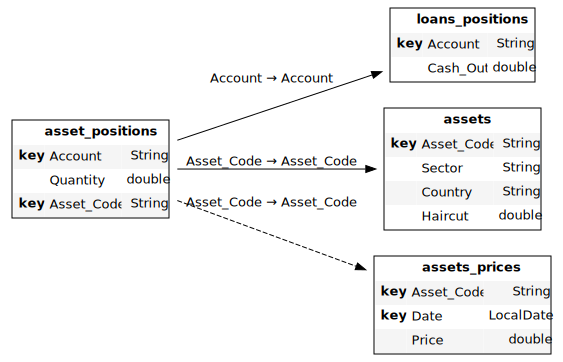

In [14]:
cube.schema

### Quick analysis with cube.visualize

In [15]:
# we can perform drill-down to different hierarchies in a pivot table
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [16]:
session.visualize("explore-dataset-using-pivot-table")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Cube structure
During cube creation, numeric values are automatically created as measures. Non numeric values are automatically translated to levels under hierarchy of the same name. This can be [configured](https://www.atoti.io/documentation/lib/atoti.html#atoti.session.Session.create_cube) differently.

In [17]:
m = cube.measures
h = cube.hierarchies
lvl = cube.levels

Before we proceed with the data aggregation aspects, let's inspect the hierarchies created

In [18]:
h

Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of Cube(_name='Collateral_Management', _hierarchies=..., _measures=Measures())>, _cube_name='Collateral_Management')

We are going to set the hierarchy *Date* as a slicing hierarchy. A slicing hierarchy will not aggregate the data on all its members.  
This means that we always view a subset of the cube by one date by default, which is usually what is needed.

In [19]:
h["Date"].slicing = True

In [20]:
m

Measures()

### Creating new measures  
From the data we have, we can derive the following:   
$Market Value = Price \times Quantity$  
$Collateral Value = Market Value \times (1 - Haircut)$   
  
The above measures are aggregated over the Account and Asset Code levels in order to compute the Collateral Shortfall at account level:  
$Collateral Shortfall = Collateral Value - Cash Out$   
Where Cash Out is also aggregated at account level           

In [21]:
m["Price"] = tt.agg.single_value(assets_prices["Price"])

In [22]:
m["Market Value"] = tt.agg.sum(
    m["Price"] * m["Quantity.SUM"], scope=tt.OriginScope(lvl["Asset_Code"])
)

In [23]:
m["Haircut"] = tt.agg.sum(assets_table["Haircut"])

m["Collateral Value"] = tt.agg.sum(
    m["Market Value"] * (1 - m["Haircut"]),
    scope=tt.OriginScope(lvl["Asset_Code"]),
)

In the `loan_position` table where the `Cash_Out` value is stored, `Account` is set as a key that is used to join the table to the base table.  
Hence, we have valid `Cash_out` value only if the `Account` is not empty. Therefore, we will perform this check using the `where` condition.

In [24]:
m["cash_out"] = tt.agg.single_value(loans_positions_table["Cash_Out"])
cash_out = tt.where(
    ~lvl["Account"].isnull(),
    m["cash_out"],
)
m["Cash Out"] = tt.agg.sum(cash_out, scope=tt.OriginScope(lvl["Account"]))

In [25]:
m["Collateral Shortfall"] = m["Collateral Value"] - m["Cash Out"]

In [26]:
m

Measures()

Let's explore this new measures.

In [27]:
# we can look at the price.VALUE across Date, further split the charts by Asset_Code
session.visualize("times-series")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [28]:
# give a meaningful title to the visualization. This helps to reconcile the objective of the visual and also could be the title of
# the widget when visual is published
session.visualize("haircut-value")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Monitoring Collateral Shortfall  
We created a pivot table for with the Collateral Shortfall, Market Value, Cash Out and Collateral Value for Accounts.  
Negative Collateral Shortfall are highlighted in red. Feel free to click on the `>` to drill-down to other hierarchies such as Sector to account for the shortfall. 

In [29]:
session.visualize("Collateral Shortfall")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In view of all accounts, using a Gauge chart will show us that we are not yet in shortfall and how far we are from it.   
The red marker shows the total Market value, which is the maximum threshold before shortfall will occur.

In [30]:
session.visualize("total-cash-out")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Total Cash out Bank wide  
  
We can use a Tree map to visualize the asset concentration. A well diversified portfolio will help to reduce the collateral risks.

In [31]:
session.visualize("Asset Concentration")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## atoti UI and Dashboard creation
Until now, we have created a few visualizations. We can right-click on the visuals to publish them as widgets.
These widgets can then be used to build a dashboard.  

<img src="http://data.atoti.io/notebooks/collateral-shortfall-monitoring/collateral_dashboard.gif" alt="collateral_dashboard" style="zoom:40%;" />

In [32]:
session.link(path="#/dashboard/3a7")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Click on the URL above to view the dashboard that was prepared. We can use the quick filter to select an account for viewing.  
We can also do a right-click drillthrough to investigate the underlying data.  
  
To play with the UI and explore the data, [you can have a look at our UI documentation here](https://www.activeviam.com/activeui/documentation/index.html).

## Simulations
Now that we have basic monitoring on Collateral Shortfall, we can do some simulations in the data cube without having to duplicate or reload data.  
  
### Setup Haircut Simulation
We are going to perform a Haircut simulation where there is a consumption slowdown in the Consumer Cyclical sector in Italy and France.  
In this use case, we will replace the value of haircut for the mentioned sector and country to see its downstream impact on the Collaterals.

The base scenario is named as _Current Market Condition_.

In [33]:
haircut_simulation = cube.create_parameter_simulation(
    "Haircut Simulation",
    measures={"Haircut parameter": 0.0},
    base_scenario_name="Current Market Condition",
    levels=[lvl["Sector"], lvl["Country"]],
)

Instead of inheriting the default value, we want the haircut applied to remain the same if no value is provided in the simulation.

In [34]:
m["Applied Haircut"] = tt.where(
    m["Haircut parameter"] != 0.0, m["Haircut parameter"], m["Haircut"]
)

Earlier on, we have defined the measure `Collateral Value`. We are going to update its definition to use the simulation measure - `Applied Haircut` instead of the initial `Haircut` value.  
Since the simulation is on the `Sector` and `Country` levels, so we add these levels to the scope of the measure.

In [35]:
m["Collateral Value"] = tt.agg.sum(
    m["Market Value"] * (1 - m["Applied Haircut"]),
    scope=tt.OriginScope(lvl["Sector"], lvl["Country"], lvl["Asset_Code"]),
)

Below, we are adding the scenario `Consumption Slowdown` where the `m[Applied Haircut]` will be adjusted for `Sector` level with value _Consumer Cyclical_ and `Country` level with value _Italy_ and _France_ as shown. 

In [36]:
haircut_simulation += ("Consumption Slowdown", "Consumer Cyclical", "Italy", 0.20)
haircut_simulation += ("Consumption Slowdown", "Consumer Cyclical", "France", 0.15)

#### Analysing the impact of Consumption Slowdown  
  
We will create a chart showing Collateral Shortfall against Account, split by *Haircut Simulation* - the Measure Simulation we just created.  
We will be able to see that with a slowdown in Italy and France, *Gates & Melinda* will go into shortfall and the shortfall amount for *Buffet* increased dramatically.   
The Consumer Cyclical  in Italy and France does not impact *Daniel EK*, *Musk* and *Niel*.

In [37]:
session.visualize("Consumption Slowdown")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

With a pivot table, we can easily see the amount of collateral generated by the *Consumer Cyclical* sector in Italy and France.

In [38]:
session.visualize("Consumption Slowdown by Sector")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Market Value Simulation
We are going to create a new set of simulation where technology sector goes into a slump and price value for the sector dipped by 30%.  
We see that while the levels we will be simulating are the same as the previous simulation, now instead of replacing the Haircut value, we will multiply the Price value by 0.7.  

In [39]:
market_value_simulation = cube.create_parameter_simulation(
    "Market Value Simulation",
    measures={"Price parameter": 1.0},
    base_scenario_name="Current Market Condition",
    levels=[lvl["Sector"], lvl["Country"]],
)

Now, we are going to cross the _Haircut Simulation_ with our _Market Value Simulation_ by updating the definition of the measure `Collateral Value`. We will multiply the `Price` measure by the `Price parameter`.

In [40]:
m["Collateral Value"] = tt.agg.sum(
    m["Price"] * m["Price parameter"] * m["Quantity.SUM"] * (1 - m["Applied Haircut"]),
    scope=tt.OriginScope(lvl["Sector"], lvl["Country"], lvl["Account"]),
)

Naturally, we could have defined the parameter simulation earlier in the use case and define the `Collateral Value` just once with the final formula above.  
However, for demonstrative purpose, we have used a sequential execution of the notebook to demonstrate the ability to chain multiple simulations together in a formula.

We will also scale the `Price` measure in the measure `Market Value`.

In [41]:
m["Market Value"] = tt.agg.sum(
    m["Price"] * m["Price parameter"] * m["Quantity.SUM"],
    scope=tt.OriginScope(lvl["Sector"], lvl["Country"], lvl["Account"]),
)

We add the scenario `Tech Bubble?` to the simulation where the `Sector` level with value _Technology_ have their price value dipped by 30%. Note that we use _None_ for the value of `Country` level. _None_ is a wildcard, which implies the value will be applied to all countries.

In [42]:
market_value_simulation += ("Tech Bubble?", "Technology", None, 0.70)

#### Analysing the impact of Technology slump  
  
As before, we plot a chart of Collateral Shortfall against Account. However, we are going to do a split by the *Market Simulation* that we just created.  
We will see the technology giant such as *Gates & Melinda* suffering greatly as their shortfall goes beyond 1.5 million.  
Likewise Buffet with 1/6 of assets in Technology also suffered.

In [43]:
session.visualize("Tech Bubble?")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

As we drill-in further to simulation for *Buffet* vs *Gates*, we see that *Buffet* has greater shortfall as they have a higher Cash Out value for the Technology sector than *Gates* while their market value was the same. 

In [44]:
session.visualize("Market Simulation - Gates vs Buffet")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Setup Cash out Simulation

The previous simulations we have done are called Measure simulations.  
There is a different kind of simulation known as Source simulation.  

In Measure simulations, we modify the value of the measures in scenarios of the simulations without duplicating data.  
Source simulation on the other hand, is a simulation created by loading a new source of modified data to the cube.  

Let's modify the loans_positions_df that was previously loaded into the cube, and increase its Cash_Out value by 10%.  
For our *Cash out simulation*, we shall load this modified dataframe directly into the table as a scenario.

In [45]:
loans_positions_df["Cash_Out"] = loans_positions_df["Cash_Out"].apply(
    lambda x: (1 + 0.1) * x
)

In [46]:
loans_positions_df

,Account,Cash_Out
0,Bezos & MacKenzie,17600000.0
1,Buffet,59400000.0
2,Daniel Ek,9900000.0
3,Gates & Melinda,18700000.0
4,Musk,9900000.0
5,Niel,15400000.0


In [47]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the table as scenarios.
predictive_simulation = loans_positions_table.scenarios["Cash out Increase"]
with session.start_transaction(scenario_name="Cash out Increase"):
    predictive_simulation.drop()  # Clear the data from the "base" scenario before loading our new data
    predictive_simulation.load_pandas(loans_positions_df)

#### Analysing the impact of increase in Cash Out

While cash out increases but collateral value remains the same, we see that the shortfall situation is worsen.

In [48]:
session.visualize("Cash out Increase")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Check out the dashboard that was prepared in advance.

In [49]:
session.link(path="#/dashboard/69e")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=collateral-monitoring" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>